# Previsão de Receita (pagamento das apólices)

## Tratamento de dados e EDA

In [2]:

#Importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge


In [3]:
# Coletando os dados 
# df_venda = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='venda')
df_receita = pd.read_excel('case_analista_de_inteligncia_e_performance_-_2023.xlsx', sheet_name='receita')

In [4]:
df_receita

,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,65.300
1,2019,1,72,57,4,1360.235
2,2019,1,72,56,3,276.490
3,2019,1,72,47,2,-1707.095
4,2019,1,72,38,3,1080.745
...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935
1076,2020,6,72,13,3,3244.695
1077,2020,6,72,12,3,267.235
1078,2020,6,72,9,12,2157.955


In [5]:
df_receita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ano           1080 non-null   int64  
 1   mes           1080 non-null   int64  
 2   seguradora    1080 non-null   int64  
 3   vendedor      1080 non-null   int64  
 4   tot_apolices  1080 non-null   int64  
 5   receita       1080 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 50.8 KB


### Verificando a distribuição da coluna receita

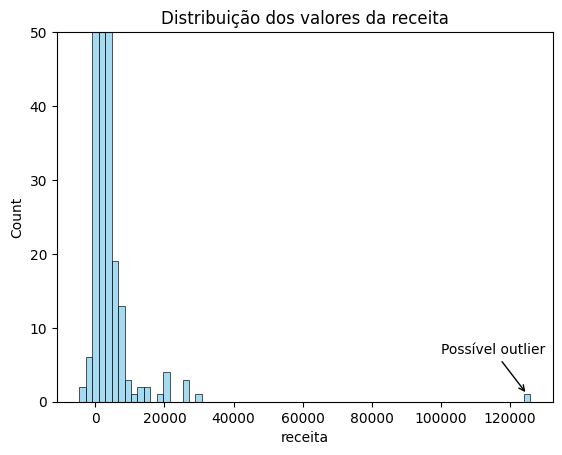

In [6]:
sns.histplot(df_receita.receita, bins=70, kde=False, color='skyblue')
#Limite o y para 50 pois não estava dando para ver as frequências dos outros valores
plt.ylim(0, 50)
plt.title('Distribuição dos valores da receita')

comentario = "Possível outlier"  
plt.annotate(comentario, xy=(125000, 1), xytext=(100000, 6.5),
             arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.show()

Como pode ser visto há um possível outlier acima de 120.000 de receita

In [7]:
#Investigando esse possível outlier
df_receita_outlier = df_receita.loc[df_receita.receita > 120000].copy()
df_receita_outlier

,ano,mes,seguradora,vendedor,tot_apolices,receita
651,2019,12,55,16,1,125950.595


Seria um bom ponto para se verificar com o TI da empresa se é um valor válido ou não.
Porém, como é um teste vou apenas verificar se ele afeta a acuracidade do modelo e remover.

In [14]:
#Removendo valores negativos pois são cancelamentos
df_receita = df_receita.query('receita >= 0')

#Adicionando uma coluna de datetime para o modelo

df_receita['data'] = df_receita.ano.astype(str) + '-' + df_receita.mes.astype(str)
df_receita['data'] = pd.to_datetime(df_receita.data)

df_receita


,ano,mes,seguradora,vendedor,tot_apolices,receita,data
0,2019,1,72,58,1,65.300,2019-01-01
1,2019,1,72,57,4,1360.235,2019-01-01
2,2019,1,72,56,3,276.490,2019-01-01
4,2019,1,72,38,3,1080.745,2019-01-01
5,2019,1,72,35,2,446.095,2019-01-01
...,...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935,2020-06-01
1076,2020,6,72,13,3,3244.695,2020-06-01
1077,2020,6,72,12,3,267.235,2020-06-01
1078,2020,6,72,9,12,2157.955,2020-06-01


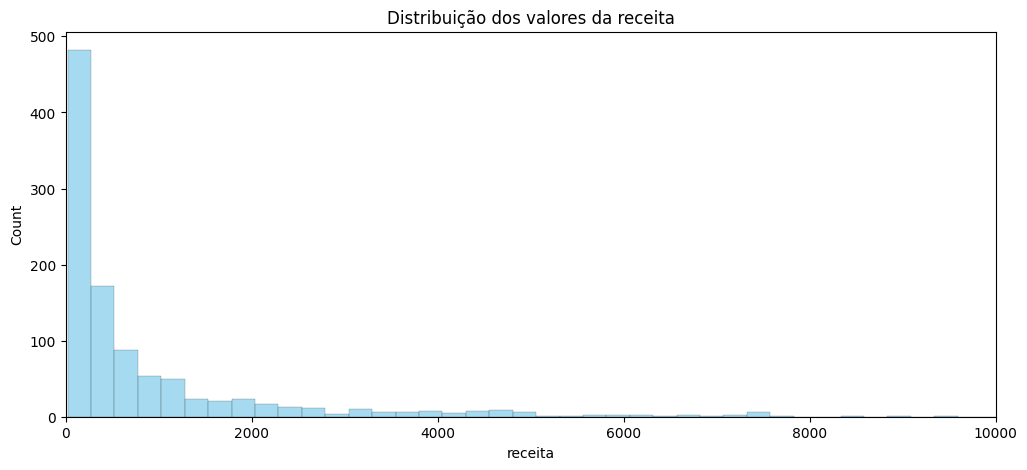

In [9]:
#Verificando a distribuição após remover os valores cancelados
plt.figure(figsize=(12, 5))
sns.histplot(df_receita.receita, bins=500, kde=False, color='skyblue')
#limitei o x para não aparecer o possível outlier
plt.xlim(0,10000)
plt.title('Distribuição dos valores da receita')
plt.show()

A distribuição dos valores da receita são similares a uma distribuição exponencial

## Criação do Modelo

### modelo Decision Tree Regressor

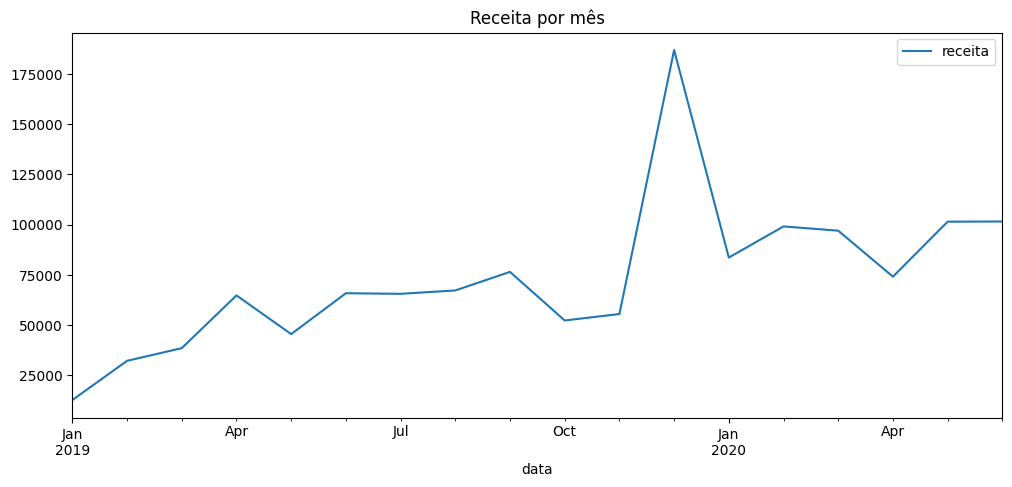

In [74]:
#Tratamento para o modelo
# plt.figure(figsize=(20, 10))
df_receita_modelo = df_receita.groupby(['data', 'ano', 'mes'])['receita'].sum().copy().reset_index()

df_receita_modelo.plot(x='data', y='receita' ,figsize=(12, 5))
plt.title('Receita por mês')
plt.show()

O nosso possível outlier afetando os valores de dezembro de 2019 causando o pico

In [79]:
# Dividindo entre Treino e Teste
df_receita_modelo['data'] = pd.to_datetime(df_receita_modelo['data'])

treino_df = df_receita_modelo[df_receita_modelo.data < '2020-04-01']
teste_df = df_receita_modelo[df_receita_modelo.data >= '2020-04-01']

features = ['data', 'ano', 'mes']

x_treino = treino_df[features]
y_treino = treino_df['receita']

x_teste = teste_df[features]
y_teste = teste_df['receita']

x_treino

,data,ano,mes
0,2019-01-01,2019,1
1,2019-02-01,2019,2
2,2019-03-01,2019,3
3,2019-04-01,2019,4
4,2019-05-01,2019,5
5,2019-06-01,2019,6
6,2019-07-01,2019,7
7,2019-08-01,2019,8
8,2019-09-01,2019,9
9,2019-10-01,2019,10


In [78]:
tree_model = DecisionTreeRegressor()
tree_model.fit(x_treino, y_treino)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[int64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>)